## We will perform anomaly detection on the error norms of the state variables of the four DC DC converters

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inLine
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize']=14,8
np.random.seed(1)
tf.random.set_seed(1)
print(tf.__version__)

2.1.0


In [2]:
dataset = pd.read_csv('../input/error-norm-of-states/HIL_200512_152440.csv')
dataset.head()

,Time,P_load3,P_load4,const_0V,delta1,delta2,delta3,delta4,factor1,factor2,factor3,factor4,sigma1,sigma2,sigma3,sigma4
0,0.0000,0.002406,0.001471,0.0,23.601076,65.77035,29.522863,15.488599,15.120029,0.0,12.461611,0.0,38.721104,65.77035,41.984474,15.488599
1,0.0002,0.046212,0.025909,0.0,55.583070,184.52864,75.012620,75.549670,69.664154,0.0,59.372864,0.0,125.247220,184.52864,134.385480,75.549670
2,0.0004,0.261675,0.140144,0.0,35.176970,242.06189,80.183846,181.319520,171.132340,0.0,136.926320,0.0,206.309310,242.06189,217.110150,181.319520
3,0.0006,0.868434,0.473722,0.0,35.144730,243.96877,62.609350,304.590400,235.681490,0.0,215.504530,0.0,270.826200,243.96877,278.113900,304.590400
4,0.0008,2.130242,1.234536,0.0,115.637910,255.41180,67.273254,413.530500,218.212480,0.0,268.353500,0.0,333.850370,255.41180,335.626740,413.530500


In [3]:
#extracting the signals after time step of 0.1 seconds
dataset = dataset[dataset['Time']>=0.1]

In [4]:
#Plotting the signals
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataset['Time'],y=dataset.factor1,mode='lines',name='Norm Difference for converter 1'))
fig.update_layout(showlegend=True)
fig.show()

### The peak in the signal is due to sudden load change which is to be included in the normal condition

In [5]:
#Standardizing the data
#from sklearn.preprocessing import StandardScaler
f1_mean,f1_std = dataset['factor1'].mean(),dataset.factor1.std()
f2_mean,f2_std = dataset.factor2.mean(),dataset.factor2.std()
f3_mean,f3_std = dataset.factor3.mean(),dataset.factor3.std()
f4_mean,f4_std = dataset.factor4.mean(),dataset.factor4.std()
dataset.factor1 = (dataset.factor1 - f1_mean)/f1_std
dataset.factor2 = (dataset.factor2 - f2_mean)/f2_std
dataset.factor3 = (dataset.factor3 - f3_mean)/f3_std
dataset.factor4 = (dataset.factor4 - f4_mean)/f4_std

### Creating sequences for LSTM

In [6]:
def create_sequences(X,Y,time_steps):
    Xs,Ys = [],[]
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:i+time_steps].values)
        Ys.append(Y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

### We will use time steps of size 15. It can be tuned as a hyperparameter

In [7]:
time_steps = 15
num_features = 1
X1,Y1 = create_sequences(dataset.factor1,dataset.factor1,time_steps)
X2,Y2 = create_sequences(dataset.factor2,dataset.factor2,time_steps)
X3,Y3 = create_sequences(dataset.factor3,dataset.factor3,time_steps)
X4,Y4 = create_sequences(dataset.factor4,dataset.factor4,time_steps)
X1 = X1.reshape(X1.shape[0],time_steps,num_features)
X2 = X2.reshape(X2.shape[0],time_steps,num_features)
X3 = X3.reshape(X3.shape[0],time_steps,num_features)
X4 = X4.reshape(X4.shape[0],time_steps,num_features)
Y1 = Y1.reshape(Y1.shape[0],num_features)
Y2 = Y2.reshape(Y2.shape[0],num_features)
Y3 = Y3.reshape(Y3.shape[0],num_features)
Y4 = Y4.reshape(Y4.shape[0],num_features)

### Building an LSTM autoencoder

In [8]:
#import libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,RepeatVector,TimeDistributed,Flatten
from keras.models import model_from_json

#for the first converter
model_one = Sequential([
    LSTM(128,input_shape=(time_steps,num_features)),
    Dropout(0.1),
    RepeatVector(time_steps),
    LSTM(128,return_sequences=True),
    Dropout(0.1),
    TimeDistributed(Dense(num_features)),
    Flatten(),
    Dense(num_features)
])
model_one.compile(loss='mae',optimizer='adam')
model_one.summary()
#training
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history = model_one.fit(X1,Y1,epochs=100,batch_size=32,validation_split=0.1,callbacks=[es],shuffle=False)

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 1)             129       
_________________________________________________________________
flatten_1 (Flatten)          (None, 15)               

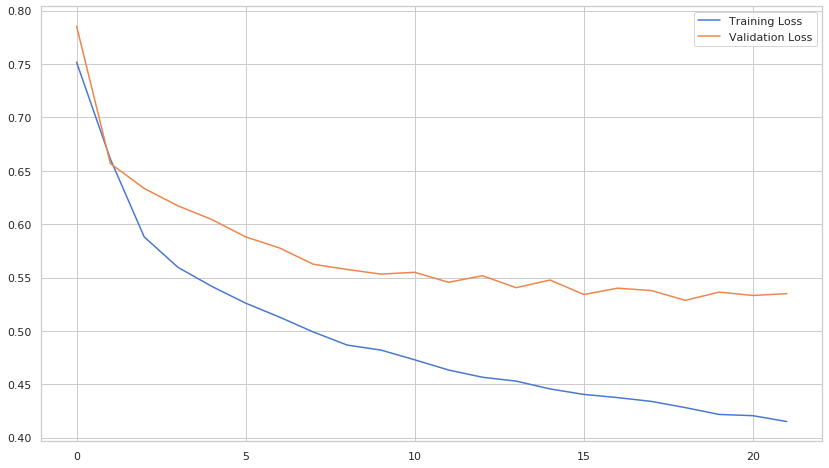

In [9]:
#visualising training and validation losses
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [10]:
#For the second converter
model_two = Sequential([
    LSTM(128,input_shape=(time_steps,num_features)),
    Dropout(0.1),
    RepeatVector(time_steps),
    LSTM(128,return_sequences=True),
    Dropout(0.1),
    TimeDistributed(Dense(num_features)),
    Flatten(),
    Dense(num_features)
])
model_two.compile(loss='mae',optimizer='adam')
model_two.summary()
#training
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history1 = model_one.fit(X2,Y2,epochs=100,batch_size=32,validation_split=0.1,callbacks=[es],shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1)             129       
_________________________________________________________________
flatten_2 (Flatten)          (None, 15)               

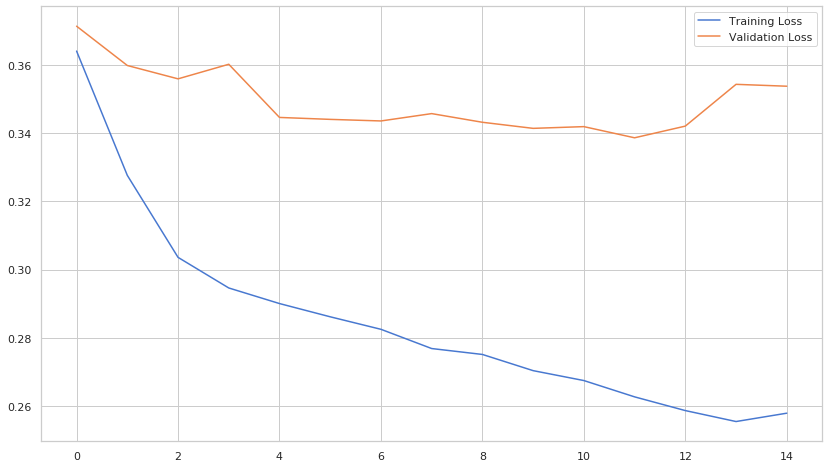

In [11]:
#visualising training and validation losses
plt.plot(history1.history['loss'],label='Training Loss')
plt.plot(history1.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [12]:
#For third converter
model_three = Sequential([
    LSTM(128,input_shape=(time_steps,num_features)),
    Dropout(0.1),
    RepeatVector(time_steps),
    LSTM(128,return_sequences=True),
    Dropout(0.1),
    TimeDistributed(Dense(num_features)),
    Flatten(),
    Dense(num_features)
])
model_three.compile(loss='mae',optimizer='adam')
model_three.summary()
#training
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history2 = model_one.fit(X3,Y3,epochs=100,batch_size=32,validation_split=0.1,callbacks=[es],shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 1)             129       
_________________________________________________________________
flatten_3 (Flatten)          (None, 15)               

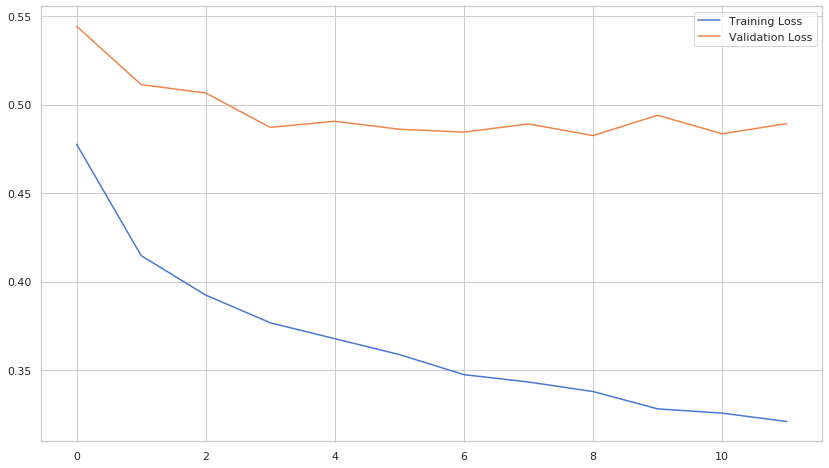

In [13]:
#visualising training and validation losses
plt.plot(history2.history['loss'],label='Training Loss')
plt.plot(history2.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [14]:
#for fourth converter
model_four = Sequential([
    LSTM(128,input_shape=(time_steps,num_features)),
    Dropout(0.1),
    RepeatVector(time_steps),
    LSTM(128,return_sequences=True),
    Dropout(0.1),
    TimeDistributed(Dense(num_features)),
    Flatten(),
    Dense(num_features)
])
model_four.compile(loss='mae',optimizer='adam')
model_four.summary()
#training
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history3 = model_one.fit(X4,Y4,epochs=100,batch_size=32,validation_split=0.1,callbacks=[es],shuffle=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 1)             129       
_________________________________________________________________
flatten_4 (Flatten)          (None, 15)               

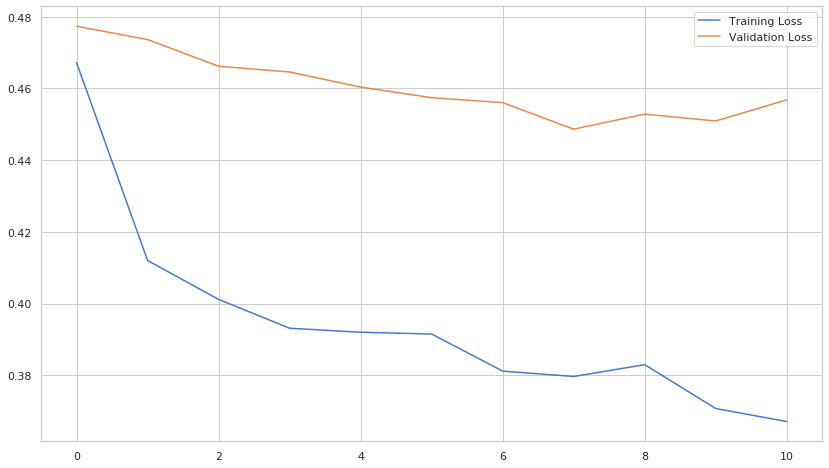

In [15]:
#visualising training and validation losses
plt.plot(history3.history['loss'],label='Training Loss')
plt.plot(history3.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

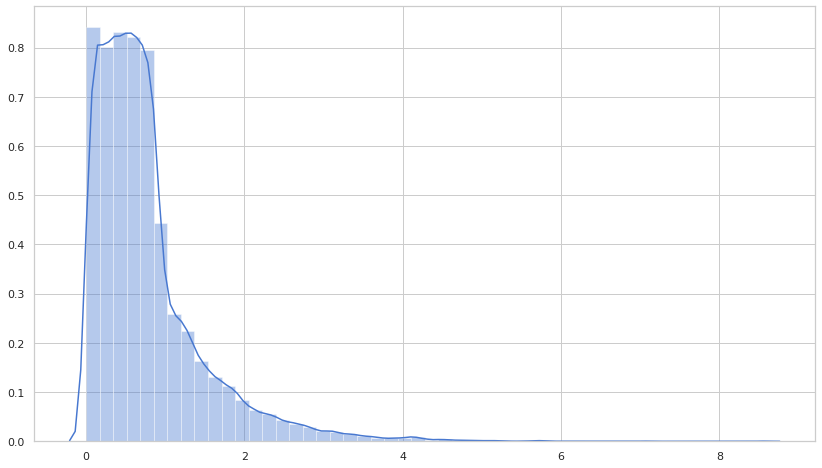

In [16]:
#Deciding the thresholds for anomaly detection
#Converter 1
x1_mae_loss = np.mean(np.abs(model_one.predict(X1)-Y1),axis=1)
x2_mae_loss = np.mean(np.abs(model_two.predict(X2)-Y2),axis=1)
x3_mae_loss = np.mean(np.abs(model_three.predict(X3)-Y3),axis=1)
x4_mae_loss = np.mean(np.abs(model_four.predict(X4)-Y4),axis=1)
sns.distplot(x1_mae_loss,kde=True)

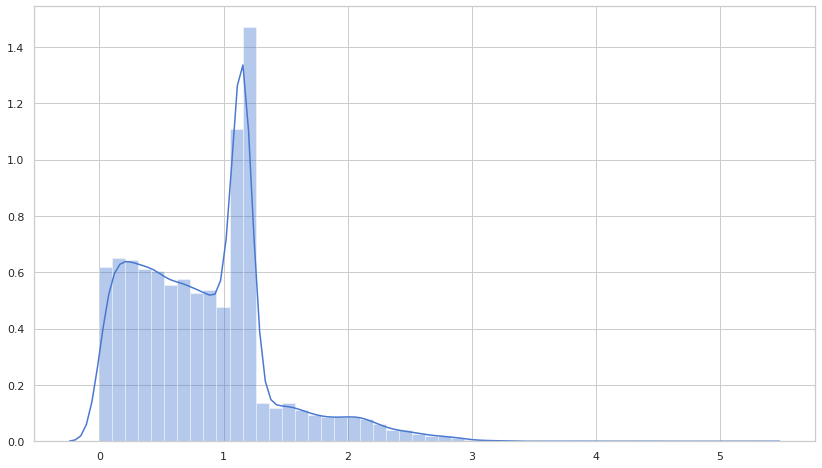

In [17]:
sns.distplot(x2_mae_loss,kde=True)

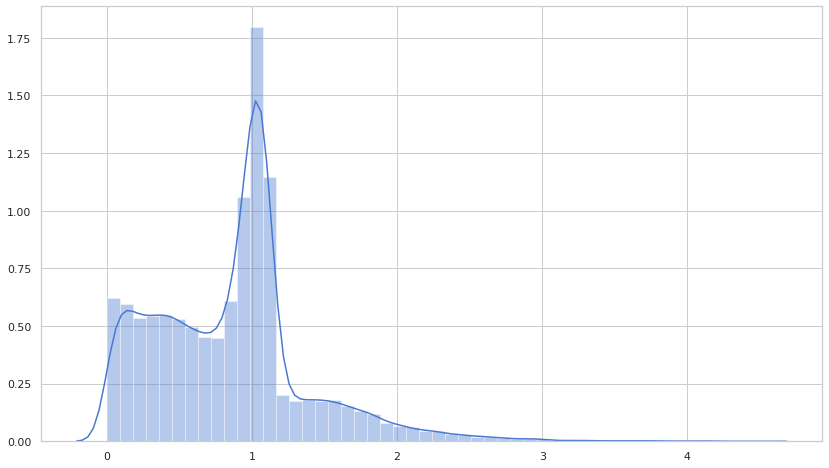

In [18]:
sns.distplot(x3_mae_loss,kde=True)

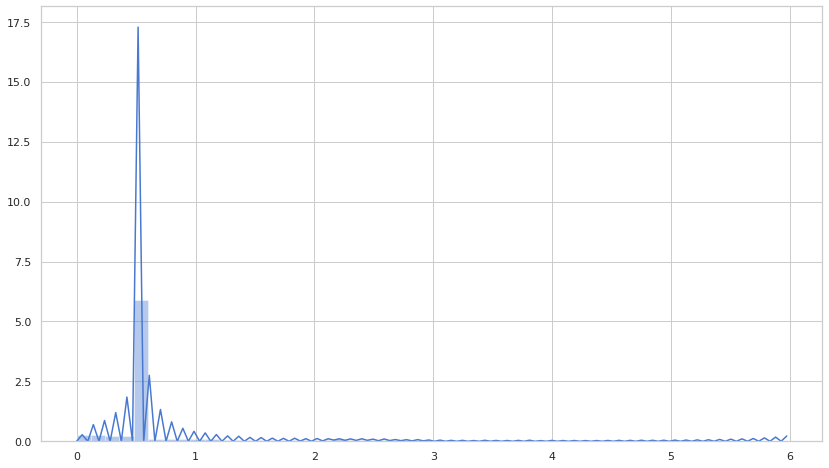

In [19]:
sns.distplot(x4_mae_loss,kde=True)

In [20]:
max(x3_mae_loss)

4.475849827629128

### Threshold for first converter is 8.4, second one will be 5.6, third one will be 4.6 and fourth one will be 6.2

In [21]:
#Saving models, weights and thresholds
model1_json = model_one.to_json()
with open("model1.json","w") as json_file:
    json_file.write(model1_json)
model_one.save_weights('model1.h5')

model2_json = model_two.to_json()
with open("model2.json","w") as json_file:
    json_file.write(model2_json)
model_two.save_weights('model2.h5')

model3_json = model_three.to_json()
with open("model3.json","w") as json_file:
    json_file.write(model3_json)
model_three.save_weights('model3.h5')

model4_json = model_four.to_json()
with open("model4.json","w") as json_file:
    json_file.write(model4_json)
model_four.save_weights('model4.h5')
